# Cherry blossoming in Japan

In [1]:
import sys
sys.path.append('../../Utilities/src')

from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import pandas as pd


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [3]:
from DA_tools.DA_tools import ribbon_plot
from DA_tools.DA_colors import *

from scipy.interpolate import BSpline
from datetime import datetime

### Import and validate dataset

In [4]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
CHERRY_BLOSSOMS_DATASET_PATH = f"{_BASE_URL}/cherry_blossoms.csv"
d = pd.read_csv(CHERRY_BLOSSOMS_DATASET_PATH, sep=';', header=0)
d.describe()

,year,doy,temp,temp_upper,temp_lower
count,1215.000000,827.000000,1124.000000,1124.000000,1124.000000
mean,1408.000000,104.540508,6.141886,7.185151,5.098941
std,350.884596,6.407036,0.663648,0.992921,0.850350
min,801.000000,86.000000,4.670000,5.450000,0.750000
25%,1104.500000,100.000000,5.700000,6.480000,4.610000
50%,1408.000000,105.000000,6.100000,7.040000,5.145000
75%,1711.500000,109.000000,6.530000,7.720000,5.542500
max,2015.000000,124.000000,8.300000,12.100000,7.740000


In [5]:

d2 = d[d.doy.notna()]  # not NaN cases on day of year


### Stan model

In [6]:
with open('cherry_fit.stan', 'r') as file:
    print(file.read())

data {
  int N; //number of measurements
  int K; //number of basis functions
  matrix [N,K] X; //design matrix
  real y[N]; //measurements
}

parameters {
  real alpha;
  vector[K] beta;
  real<lower=0> sigma;
}

transformed parameters {
  vector[N] mu = X*beta+alpha;
}

model {
  alpha ~ normal(100,10);
  beta ~ normal(0,10);
  sigma ~ exponential(1);
  y ~ normal(mu,sigma);
}

generated quantities {
  real y_pred[N];
  for (i in 1:N) {
    y_pred[i] = normal_rng(mu[i],sigma);
  }
}



In [8]:
cherry_fit=CmdStanModel(stan_file='cherry_fit.stan')

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/j5/wr2j95x534x62nm4sfx97cbc0000gn/T/tmp_v650wlm/tmpr1tnwitc
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 6 - Linear models/Splines/cherry_fit


Text(0, 0.5, 'basis')

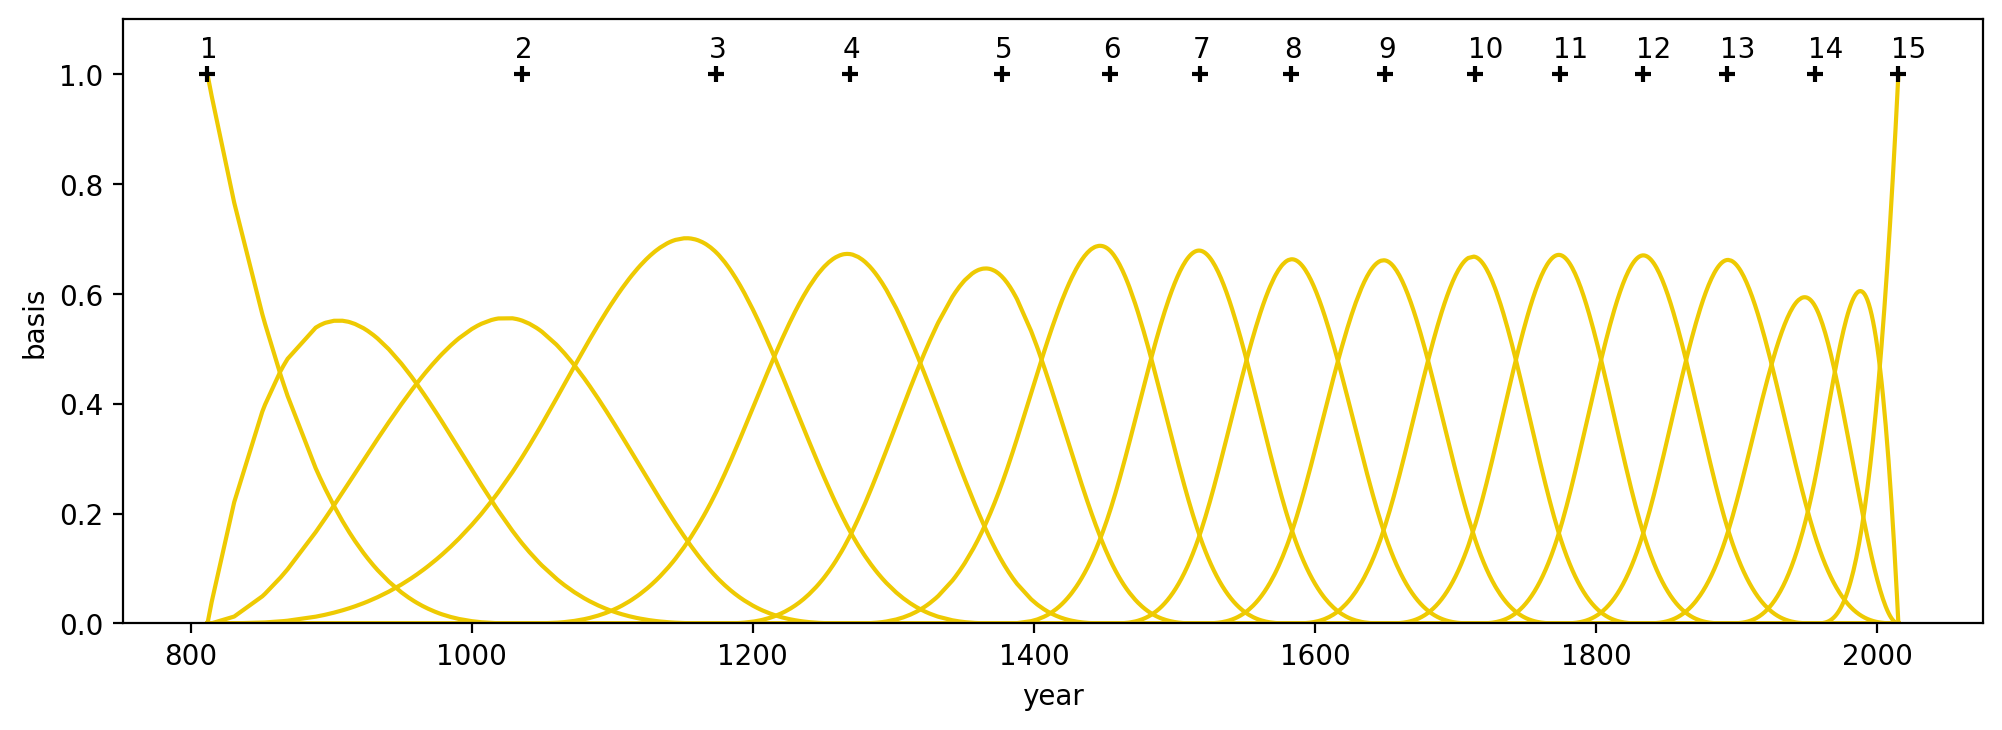

In [10]:
spl_order=3
num_knots = 15
knot_list = np.quantile(d2.year, np.linspace(0, 1, num_knots))

knots = np.pad(knot_list, (spl_order, spl_order), mode="edge")
B = BSpline(knots, np.identity(num_knots + 2), k=spl_order)(d2.year.values)

_, ax = plt.subplots(1, 1, figsize=(12, 4))
for i in range(num_knots+2):
    ax.plot(d2.year, (B[:, i]), color=DARK,zorder=0)
    if i<num_knots:
        ax.text(s='{}'.format(i+1),x=knot_list[i]-5,y=1.03)
        ax.scatter(knot_list[i],1,marker='+',color='black',zorder=1)
ax.set_ylim((0,1.1))
ax.set_xlabel("year")
ax.set_ylabel("basis")

In [11]:
data_fit = dict(N=B.shape[0],
                K=B.shape[1], 
                X=B, 
                y=d2.doy.values)
fit = cherry_fit.sample(data=data_fit, seed=29052020)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


In [12]:
az.summary(fit,var_names=['alpha','beta','sigma'],kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,103.370,2.426,98.752,107.717
beta[0],-3.084,3.961,-10.405,4.332
beta[1],-0.890,3.917,-8.157,6.383
beta[2],-1.038,3.651,-7.835,6.023
beta[3],4.804,2.939,-0.904,9.953
beta[4],-0.841,2.914,-6.117,4.665
beta[5],4.294,2.962,-1.338,9.796
beta[6],-5.358,2.848,-10.527,0.068
beta[7],7.807,2.902,2.335,13.322
beta[8],-1.004,2.926,-6.562,4.418


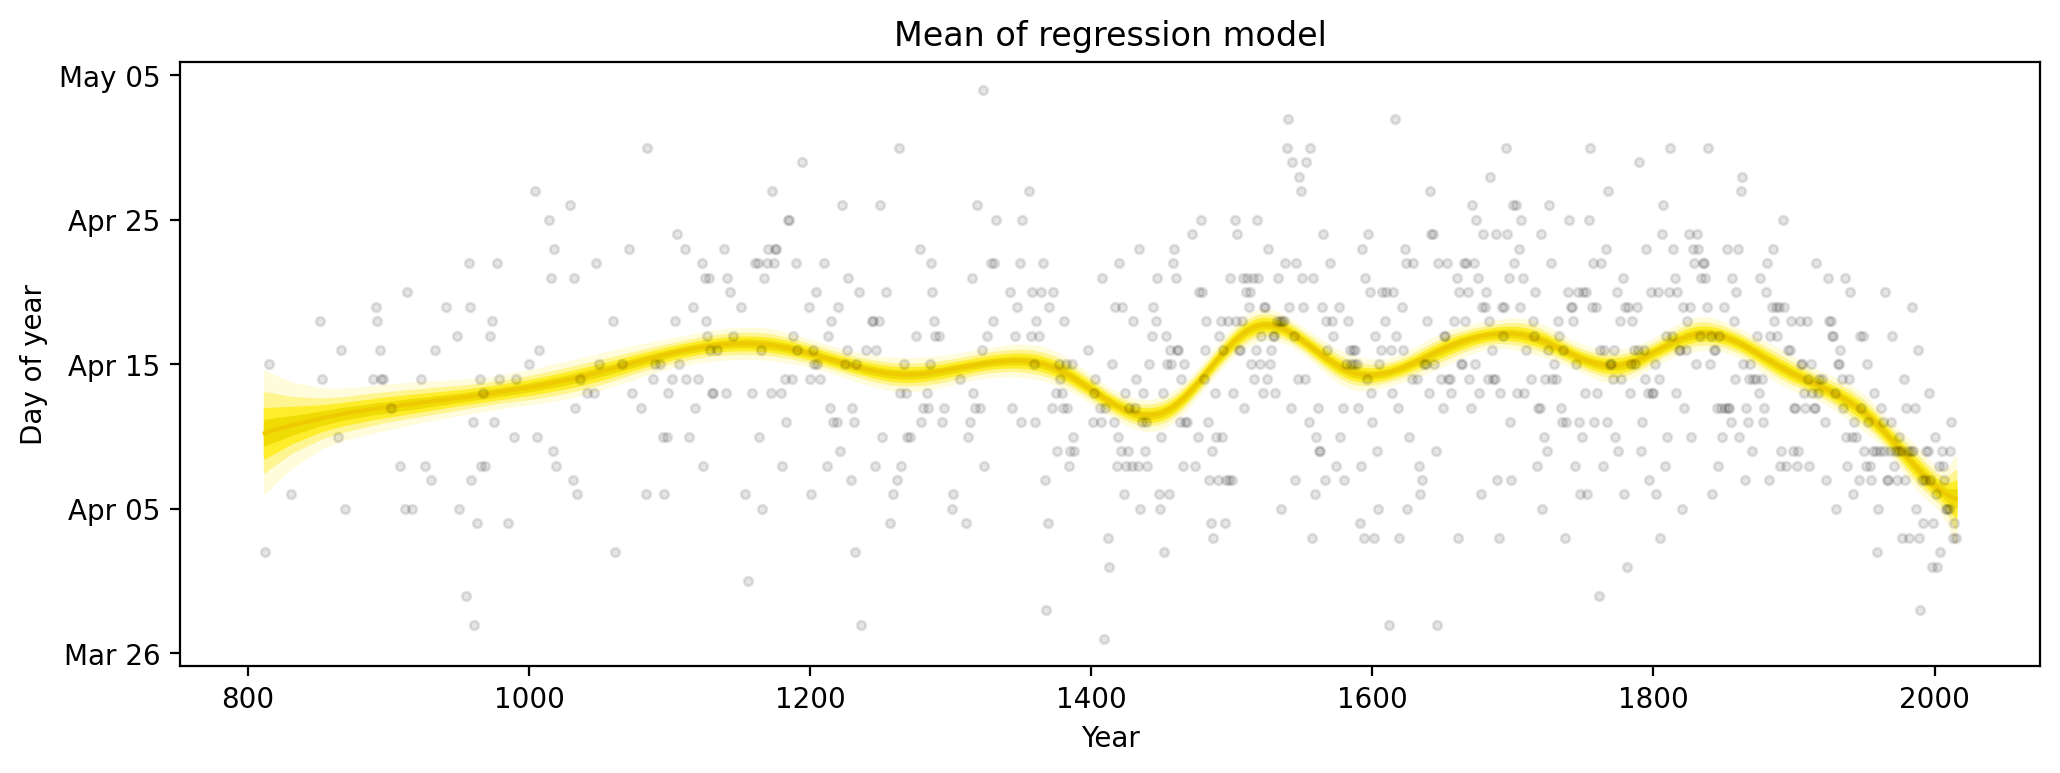

In [13]:
mu_fit = fit.stan_variable('mu')
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
axes = ribbon_plot(d2.year.values,mu_fit,axes,supress_warning=True)
axes.scatter(d2.year.values,d2.doy.values,color='black',alpha=0.1,s=10)
axes.set_xlabel('Year')
axes.set_ylabel('Day of year')
yt = [85,95,105,115,125]
yt_md = map(lambda x:datetime.strptime(x,'%j'),map(str,yt))
yt_lab = [*map(lambda x:datetime.strftime(x,'%b %d'),yt_md)]
axes.set_yticks(yt)
axes.set_yticklabels(yt_lab)
axes.set_title('Mean of regression model')
plt.show()

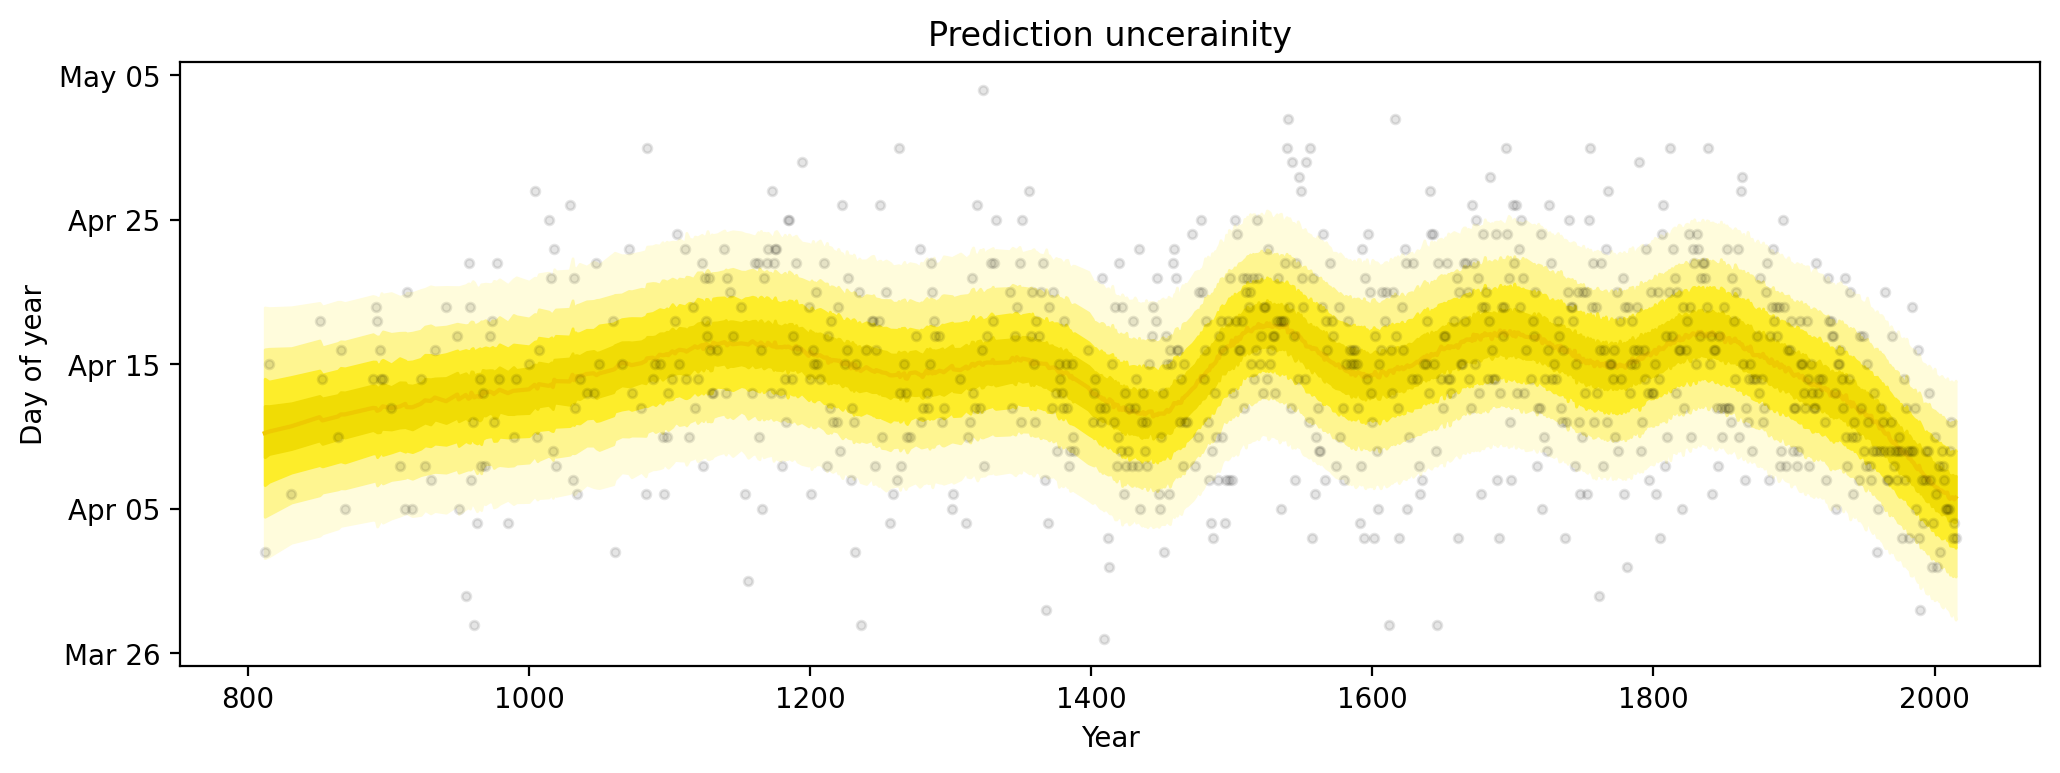

In [15]:
y_pred=fit.stan_variable('y_pred')
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
axes=ribbon_plot(d2.year.values,y_pred,axes,supress_warning=True)
axes.scatter(d2.year.values,d2.doy.values,color='black',alpha=0.1,s=10)
axes.set_xlabel('Year')
axes.set_ylabel('Day of year')

axes.set_yticks(yt)
axes.set_yticklabels(yt_lab)
axes.set_title('Prediction uncerainity')

plt.show()
